<a href="https://colab.research.google.com/github/tamara-kostova/IIS/blob/master/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing packages and importing libraries

In [ ]:
!pip install torch==2.1.0
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import Actor
from tqdm import tqdm
from torch.optim import SparseAdam
from torch_geometric.nn import Linear, SAGEConv
from torch.nn.functional import dropout
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch

# **EXERCISE 1**

Function for training the model

In [ ]:
def train_node_embeddings(model, epochs=5, batch_size=32, lr=0.01, device='cpu'):
    model = model.to(device)

    loader = model.loader(batch_size=batch_size, shuffle=True, num_workers=0)

    optimizer = SparseAdam(list(model.parameters()), lr=lr)

    model.train()

    for epoch in range(epochs):
        train_loss = 0

        for pos_rw, neg_rw in tqdm(loader):
            optimizer.zero_grad()

            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()

            optimizer.step()

            train_loss += loss.item()

        train_loss = train_loss / len(loader)

        print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}')

In [ ]:
data = Actor('../data')
dataset = data[0]

Node2Vec model

In [ ]:
model = Node2Vec(dataset.edge_index,
                     embedding_dim=50,
                     walk_length=30,
                     context_size=10,
                     walks_per_node=20,
                     num_negative_samples=1,
                     p=200, q=1,
                     sparse=True)
train_node_embeddings(model, epochs=50)

100%|██████████| 238/238 [00:52<00:00,  4.52it/s]


Epoch: 00, Loss: 2.1309


100%|██████████| 238/238 [00:43<00:00,  5.51it/s]


Epoch: 01, Loss: 0.9468


100%|██████████| 238/238 [00:42<00:00,  5.55it/s]


Epoch: 02, Loss: 0.8572


100%|██████████| 238/238 [00:42<00:00,  5.63it/s]


Epoch: 03, Loss: 0.8368


100%|██████████| 238/238 [00:43<00:00,  5.51it/s]


Epoch: 04, Loss: 0.8290


100%|██████████| 238/238 [00:42<00:00,  5.60it/s]


Epoch: 05, Loss: 0.8248


100%|██████████| 238/238 [00:41<00:00,  5.80it/s]


Epoch: 06, Loss: 0.8219


100%|██████████| 238/238 [00:43<00:00,  5.42it/s]


Epoch: 07, Loss: 0.8207


100%|██████████| 238/238 [00:42<00:00,  5.54it/s]


Epoch: 08, Loss: 0.8191


100%|██████████| 238/238 [00:42<00:00,  5.54it/s]


Epoch: 09, Loss: 0.8182


100%|██████████| 238/238 [00:43<00:00,  5.49it/s]


Epoch: 10, Loss: 0.8174


100%|██████████| 238/238 [00:43<00:00,  5.44it/s]


Epoch: 11, Loss: 0.8174


100%|██████████| 238/238 [00:43<00:00,  5.48it/s]


Epoch: 12, Loss: 0.8168


100%|██████████| 238/238 [00:43<00:00,  5.52it/s]


Epoch: 13, Loss: 0.8162


100%|██████████| 238/238 [00:42<00:00,  5.54it/s]


Epoch: 14, Loss: 0.8155


100%|██████████| 238/238 [00:43<00:00,  5.53it/s]


Epoch: 15, Loss: 0.8154


100%|██████████| 238/238 [00:44<00:00,  5.36it/s]


Epoch: 16, Loss: 0.8154


100%|██████████| 238/238 [00:43<00:00,  5.45it/s]


Epoch: 17, Loss: 0.8150


100%|██████████| 238/238 [00:43<00:00,  5.49it/s]


Epoch: 18, Loss: 0.8153


100%|██████████| 238/238 [00:41<00:00,  5.80it/s]


Epoch: 19, Loss: 0.8148


100%|██████████| 238/238 [00:42<00:00,  5.62it/s]


Epoch: 20, Loss: 0.8146


100%|██████████| 238/238 [00:43<00:00,  5.49it/s]


Epoch: 21, Loss: 0.8146


100%|██████████| 238/238 [00:43<00:00,  5.43it/s]


Epoch: 22, Loss: 0.8149


100%|██████████| 238/238 [00:43<00:00,  5.52it/s]


Epoch: 23, Loss: 0.8144


100%|██████████| 238/238 [00:43<00:00,  5.53it/s]


Epoch: 24, Loss: 0.8147


100%|██████████| 238/238 [00:43<00:00,  5.41it/s]


Epoch: 25, Loss: 0.8146


100%|██████████| 238/238 [00:43<00:00,  5.50it/s]


Epoch: 26, Loss: 0.8145


100%|██████████| 238/238 [00:41<00:00,  5.77it/s]


Epoch: 27, Loss: 0.8143


100%|██████████| 238/238 [00:42<00:00,  5.57it/s]


Epoch: 28, Loss: 0.8145


100%|██████████| 238/238 [00:42<00:00,  5.55it/s]


Epoch: 29, Loss: 0.8146


100%|██████████| 238/238 [00:43<00:00,  5.51it/s]


Epoch: 30, Loss: 0.8148


100%|██████████| 238/238 [00:42<00:00,  5.60it/s]


Epoch: 31, Loss: 0.8142


100%|██████████| 238/238 [00:42<00:00,  5.59it/s]


Epoch: 32, Loss: 0.8145


100%|██████████| 238/238 [00:42<00:00,  5.64it/s]


Epoch: 33, Loss: 0.8141


100%|██████████| 238/238 [00:42<00:00,  5.64it/s]


Epoch: 34, Loss: 0.8140


100%|██████████| 238/238 [00:43<00:00,  5.50it/s]


Epoch: 35, Loss: 0.8144


100%|██████████| 238/238 [00:41<00:00,  5.71it/s]


Epoch: 36, Loss: 0.8140


100%|██████████| 238/238 [00:42<00:00,  5.61it/s]


Epoch: 37, Loss: 0.8142


100%|██████████| 238/238 [00:42<00:00,  5.54it/s]


Epoch: 38, Loss: 0.8138


100%|██████████| 238/238 [00:42<00:00,  5.56it/s]


Epoch: 39, Loss: 0.8142


100%|██████████| 238/238 [00:42<00:00,  5.55it/s]


Epoch: 40, Loss: 0.8140


100%|██████████| 238/238 [00:40<00:00,  5.91it/s]


Epoch: 41, Loss: 0.8138


100%|██████████| 238/238 [00:43<00:00,  5.47it/s]


Epoch: 42, Loss: 0.8142


100%|██████████| 238/238 [00:42<00:00,  5.61it/s]


Epoch: 43, Loss: 0.8143


100%|██████████| 238/238 [00:42<00:00,  5.64it/s]


Epoch: 44, Loss: 0.8139


100%|██████████| 238/238 [00:42<00:00,  5.58it/s]


Epoch: 45, Loss: 0.8139


100%|██████████| 238/238 [00:42<00:00,  5.56it/s]


Epoch: 46, Loss: 0.8138


100%|██████████| 238/238 [00:42<00:00,  5.59it/s]


Epoch: 47, Loss: 0.8142


100%|██████████| 238/238 [00:40<00:00,  5.86it/s]


Epoch: 48, Loss: 0.8141


100%|██████████| 238/238 [00:41<00:00,  5.72it/s]

Epoch: 49, Loss: 0.8138


Split the dataset

In [ ]:
labels = dataset.y.detach().cpu().numpy()
node_embeddings = model().detach().cpu().numpy()

train_x, test_x, train_y, test_y = train_test_split(node_embeddings, labels, test_size=0.15, stratify=labels)

Train a Random Forest Classifier

In [ ]:
classifier = RandomForestClassifier(n_estimators=75)
classifier.fit(train_x, train_y)

preds = classifier.predict(test_x)

Results

In [ ]:
print('Node embeddings results:')
print(f'Accuracy: {accuracy_score(preds, test_y)}')
print(f'Precision: {precision_score(preds, test_y, average="micro")}')
print(f'Recall: {recall_score(preds, test_y, average="micro")}')
print(f'F1 score: {f1_score(preds, test_y, average="micro")}')

Node embeddings results:
Accuracy: 0.22631578947368422
Precision: 0.22631578947368422
Recall: 0.22631578947368422
F1 score: 0.22631578947368422


Visualization

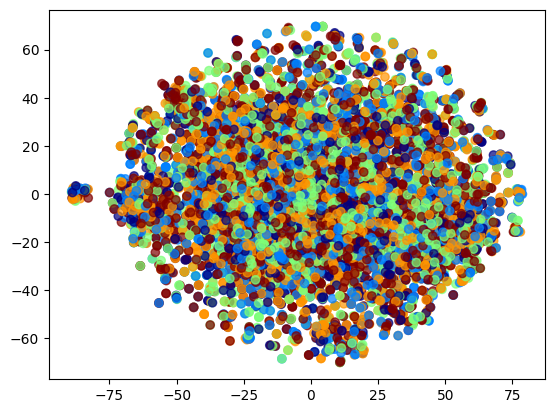

In [ ]:
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1],
            c=labels, cmap='jet', alpha=0.7)

plt.show()

# **EXERCISE 2**

Graph Convolutional Network Model

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = SAGEConv((-1, -1), 128)
        self.conv2 = SAGEConv((-1, -1), 256)

        self.linear1 = Linear(256, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).tanh()
        x = dropout(x, p=0.4)

        x = self.conv2(x, edge_index).tanh()
        x = dropout(x, p=0.4)

        x = self.linear1(x)

        return x

Function for training GCN model

In [ ]:
def train_gcn(model, dataset, optimizer, criterion, epochs=5):
    if len(dataset.train_mask.shape) > 1:
        train_mask = dataset.train_mask[:, 0]
    else:
        train_mask = dataset.train_mask

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(dataset.x, dataset.edge_index)
        loss = criterion(out[train_mask],
                         dataset.y[train_mask])
        loss.backward()
        optimizer.step()

        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

In [ ]:
model2 = GCN(num_classes=5)

optimizer = Adam(model2.parameters(), lr=0.01)

criterion = CrossEntropyLoss()

Visualization before training

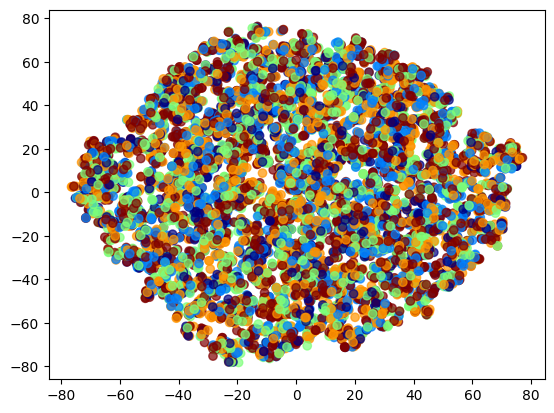

In [ ]:
node_embeddings_gcn = model2(dataset.x, dataset.edge_index).detach().cpu().numpy()
tsne = TSNE(n_components=2)
node_embeddings_gcn_2d = tsne.fit_transform(node_embeddings_gcn)

plt.scatter(node_embeddings_gcn_2d[:, 0], node_embeddings_gcn_2d[:, 1],
            c=labels, cmap='jet', alpha=0.7)

plt.show()

In [ ]:
train_gcn(model2, dataset, optimizer, criterion, 1000)

Epoch: 000, Loss: 1.6150
Epoch: 001, Loss: 1.5452
Epoch: 002, Loss: 1.4502
Epoch: 003, Loss: 1.3667
Epoch: 004, Loss: 1.2427
Epoch: 005, Loss: 1.1334
Epoch: 006, Loss: 1.0582
Epoch: 007, Loss: 0.9753
Epoch: 008, Loss: 0.8995
Epoch: 009, Loss: 0.8267
Epoch: 010, Loss: 0.7764
Epoch: 011, Loss: 0.7148
Epoch: 012, Loss: 0.6618
Epoch: 013, Loss: 0.6326
Epoch: 014, Loss: 0.5822
Epoch: 015, Loss: 0.5596
Epoch: 016, Loss: 0.5280
Epoch: 017, Loss: 0.5004
Epoch: 018, Loss: 0.4774
Epoch: 019, Loss: 0.4433
Epoch: 020, Loss: 0.4312
Epoch: 021, Loss: 0.4060
Epoch: 022, Loss: 0.3971
Epoch: 023, Loss: 0.3812
Epoch: 024, Loss: 0.3708
Epoch: 025, Loss: 0.3532
Epoch: 026, Loss: 0.3312
Epoch: 027, Loss: 0.3278
Epoch: 028, Loss: 0.3184
Epoch: 029, Loss: 0.3246
Epoch: 030, Loss: 0.3080
Epoch: 031, Loss: 0.3021
Epoch: 032, Loss: 0.2798
Epoch: 033, Loss: 0.2819
Epoch: 034, Loss: 0.2812
Epoch: 035, Loss: 0.2785
Epoch: 036, Loss: 0.2711
Epoch: 037, Loss: 0.2508
Epoch: 038, Loss: 0.2613
Epoch: 039, Loss: 0.2521


In [67]:
train_x, test_x, train_y, test_y = train_test_split(node_embeddings_gcn, labels,
                                                    test_size=0.1,
                                                    stratify=labels)

classifier2 = RandomForestClassifier(n_estimators=70)
classifier2.fit(train_x, train_y)

preds2 = classifier2.predict(test_x)

**GCN** results

In [68]:
print('GCN results:')
print(f'Accuracy: {accuracy_score(preds2, test_y)}')
print(f'Precision: {precision_score(preds2, test_y, average="micro")}')
print(f'Recall: {recall_score(preds2, test_y, average="micro")}')
print(f'F1 score: {f1_score(preds2, test_y, average="micro")}')

GCN results:
Accuracy: 0.5631578947368421
Precision: 0.5631578947368421
Recall: 0.5631578947368421
F1 score: 0.5631578947368421


Visualization after training

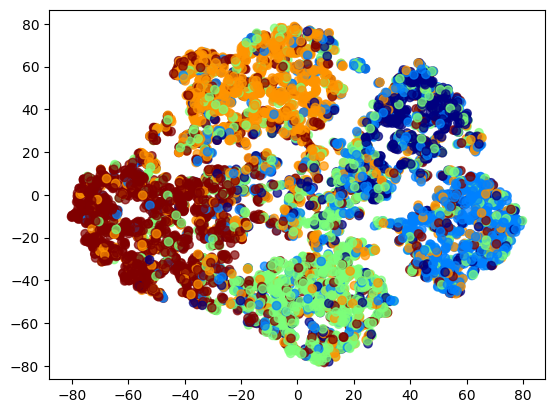

In [ ]:
node_embeddings_gcn = model2(dataset.x, dataset.edge_index).detach().cpu().numpy()



tsne = TSNE(n_components=2)
node_embeddings_gcn_2d = tsne.fit_transform(node_embeddings_gcn)

plt.scatter(node_embeddings_gcn_2d[:, 0], node_embeddings_gcn_2d[:, 1],
            c=labels, cmap='jet', alpha=0.7)

plt.show()